## IMPORTS

In [93]:
import pandas as pd
import numpy as np
import env
import zwrangle as wr

from scipy import stats
from scipy.stats import pearsonr, spearmanr

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression


from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

## ACQUIRE & PREPARE 

#### Acquire
- Data acquired from CodeUp Database
-  ***PUT NUMBER OF ROWS X COLUMNS HERE***

#### Prepare Actions:
- Drop null values from columns
- Rename columns for ease of delivery
- Remove outliers from dataset
- Split data into train/val/test datasets

#### Functions called from wrangle.py:
1. get_zillow()
2. prep_zillow(df)
3. remove_outliers(df, columns)
4. split_zillow(df)

In [2]:
# Importing my data from mySQL
df = wr.get_zillow()

In [3]:
def get_zillow():
    """ This function pulls information from the mySQL zillow database and returns it as a
    pandas dataframe"""
    url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/zillow'
    sql = """ select bedroomcnt, bathroomcnt,
calculatedfinishedsquarefeet, fips, lotsizesquarefeet,
 taxvaluedollarcnt, yearbuilt, taxamount
 from properties_2017 where propertylandusetypeid = '261' limit 1500000 """
    df = pd.read_sql(sql, url)
    return df

In [6]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,taxvaluedollarcnt,yearbuilt,assessmentyear,taxamount
0,0.0,0.0,NaN,6037.0,4083.0,27516.0,NaN,2015.0,NaN
1,0.0,0.0,NaN,6037.0,11975.0,10.0,NaN,2016.0,NaN
2,0.0,0.0,NaN,6037.0,9403.0,10.0,NaN,2016.0,NaN
3,0.0,0.0,NaN,6037.0,3817.0,2108.0,NaN,2016.0,174.21
4,4.0,2.0,3633.0,6037.0,9826.0,296425.0,2005.0,2016.0,6941.39


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 9 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   bedroomcnt                    1499994 non-null  float64
 1   bathroomcnt                   1499994 non-null  float64
 2   calculatedfinishedsquarefeet  1494108 non-null  float64
 3   fips                          1500000 non-null  float64
 4   lotsizesquarefeet             1490627 non-null  float64
 5   taxvaluedollarcnt             1499651 non-null  float64
 6   yearbuilt                     1493515 non-null  float64
 7   assessmentyear                1499999 non-null  float64
 8   taxamount                     1496901 non-null  float64
dtypes: float64(9)
memory usage: 103.0 MB


In [8]:
# Changing variable name in case I need to return to the original df
zillow = df

In [9]:
#Prepping df according to guidelines above
zillow = wr.prep_zillow(df)

In [10]:
zillow.head()

,beds,baths,sq_ft,fips,lot_size,tax_val,year,assessmentyear,tax_amt,county,Los Angeles,Orange County,Ventura,yard_sqft
4,4.0,2.0,3633.0,6037.0,9826.0,296425.0,2005.0,2016.0,6941.39,Los Angeles,1,0,0,6193.0
7,3.0,2.0,2077.0,6037.0,6490.0,646760.0,1926.0,2016.0,7924.68,Los Angeles,1,0,0,4413.0
11,0.0,0.0,1200.0,6037.0,4054.0,5328.0,1972.0,2016.0,91.60,Los Angeles,1,0,0,2854.0
14,0.0,0.0,171.0,6037.0,13002.0,6920.0,1973.0,2016.0,255.17,Los Angeles,1,0,0,12831.0
15,0.0,0.0,203.0,6037.0,17359.0,14166.0,1960.0,2016.0,163.79,Los Angeles,1,0,0,17156.0


In [11]:
# Taking a look before removing outliers
zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
beds,1483530.0,3.300795,0.929669,0.00,3.0000,3.0,4.00,2.500000e+01
baths,1483530.0,2.236626,0.985999,0.00,2.0000,2.0,3.00,2.000000e+01
sq_ft,1483530.0,1860.439700,1239.380037,1.00,1258.0000,1622.0,2204.00,9.525760e+05
fips,1483530.0,6048.364934,20.415628,6037.00,6037.0000,6037.0,6059.00,6.111000e+03
lot_size,1483530.0,10937.035812,314426.497033,104.00,5637.0000,6760.0,8545.00,3.710005e+08
tax_val,1483530.0,458713.032262,667602.239161,22.00,188746.0000,327671.0,533120.75,9.018846e+07
year,1483530.0,1960.848509,22.026673,1801.00,1949.0000,1958.0,1975.00,2.016000e+03
assessmentyear,1483530.0,2015.999447,0.032938,2014.00,2016.0000,2016.0,2016.00,2.016000e+03
tax_amt,1483530.0,5589.462899,7696.330741,13.36,2536.4425,4104.6,6389.85,1.078102e+06
Los Angeles,1483530.0,0.665188,0.471925,0.00,0.0000,1.0,1.00,1.000000e+00


In [12]:
#******FEATURE ENGINEERING**************

# # Reassign county names from FIPS data. I'll keep fips column for ease of use with numeric data
# zillow['county']= zillow['fips'].replace({6037: 'Los Angeles', 6059: 'Orange County', 6111: 'Ventura'})

# # New metric that measures yard size
# zillow['yard_sqft']= zillow['lot_size'] - zillow['sq_ft']

In [13]:
# blah = pd.get_dummies(zillow['county'], drop_first=False)
# zillow= pd.concat([zillow, blah], axis=1)

# zillow.columns

In [14]:
# Identify which fields carry outliers and isolate them into a list
outliers = ['beds', 'baths', 'tax_amt', 'lot_size', 'sq_ft', 'tax_val', 'yard_sqft']

#Remove outliers from df
zillow = wr.remove_outliers(zillow, outliers)

In [15]:
zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
beds,1103693.0,3.188689,0.771598,2.00,3.00,3.00,4.00,5.00
baths,1103693.0,1.991291,0.683009,0.50,2.00,2.00,2.00,4.50
sq_ft,1103693.0,1583.905562,507.912057,132.00,1206.00,1496.00,1888.00,3057.00
fips,1103693.0,6047.911261,20.186906,6037.00,6037.00,6037.00,6059.00,6111.00
lot_size,1103693.0,6581.578962,1624.412435,1759.00,5505.00,6433.00,7502.00,12005.00
tax_val,1103693.0,313852.440904,188459.680457,2080.00,168127.00,285956.00,432901.00,855673.00
year,1103693.0,1958.016282,20.267185,1807.00,1948.00,1956.00,1970.00,2016.00
assessmentyear,1103693.0,2015.999713,0.023795,2014.00,2016.00,2016.00,2016.00,2016.00
tax_amt,1103693.0,3923.285130,2151.723849,16.48,2308.99,3629.75,5268.17,11643.32
Los Angeles,1103693.0,0.680028,0.466466,0.00,0.00,1.00,1.00,1.00


In [16]:
#Confirming that my null values are gone
zillow.isnull().sum()

beds              0
baths             0
sq_ft             0
fips              0
lot_size          0
tax_val           0
year              0
assessmentyear    0
tax_amt           0
county            0
Los Angeles       0
Orange County     0
Ventura           0
yard_sqft         0
dtype: int64

### Splitting Data

In [17]:
train, test = train_test_split(zillow, test_size=.2, random_state=123)
train, val = train_test_split(train, 
                                       test_size=.3, 
                                       random_state=123)
train.shape, val.shape, test.shape

((618067, 14), (264887, 14), (220739, 14))

In [18]:
train.columns

Index(['beds', 'baths', 'sq_ft', 'fips', 'lot_size', 'tax_val', 'year',
       'assessmentyear', 'tax_amt', 'county', 'Los Angeles', 'Orange County',
       'Ventura', 'yard_sqft'],
      dtype='object')

In [19]:
train.head(2)

,beds,baths,sq_ft,fips,lot_size,tax_val,year,assessmentyear,tax_amt,county,Los Angeles,Orange County,Ventura,yard_sqft
256228,3.0,2.0,1244.0,6059.0,6100.0,68944.0,1968.0,2016.0,1011.66,Orange County,0,1,0,4856.0
1313460,3.0,1.0,1824.0,6037.0,3530.0,345000.0,1923.0,2016.0,4287.94,Los Angeles,1,0,0,1706.0


### EXPLORATION

#### Correlation and Distribution

In [20]:
# Returns correlation of all values in zillow dataset
corr =train.corr(method='spearman')
corr

,beds,baths,sq_ft,fips,lot_size,tax_val,year,assessmentyear,tax_amt,Los Angeles,Orange County,Ventura,yard_sqft
beds,1.000000,0.584833,0.610030,0.219384,0.198572,0.182136,0.433002,0.004226,0.180112,-0.219259,0.171863,0.107806,0.014149
baths,0.584833,1.000000,0.770304,0.235187,0.170862,0.323810,0.580874,0.003471,0.318800,-0.239377,0.202503,0.093362,-0.062207
sq_ft,0.610030,0.770304,1.000000,0.230425,0.274568,0.355577,0.495558,0.002341,0.348050,-0.235562,0.202764,0.086166,-0.023573
fips,0.219384,0.235187,0.230425,1.000000,0.026654,0.170461,0.440315,0.005021,0.092006,-0.986825,0.730148,0.556157,-0.044019
lot_size,0.198572,0.170862,0.274568,0.026654,1.000000,0.055882,0.084576,0.001036,0.063747,-0.016485,-0.022000,0.065253,0.941036
tax_val,0.182136,0.323810,0.355577,0.170461,0.055882,1.000000,0.225141,-0.000384,0.971070,-0.176981,0.161482,0.049776,-0.049427
year,0.433002,0.580874,0.495558,0.440315,0.084576,0.225141,1.000000,0.003417,0.219708,-0.439759,0.343648,0.217940,-0.060863
assessmentyear,0.004226,0.003471,0.002341,0.005021,0.001036,-0.000384,0.003417,1.000000,-0.000860,-0.005334,0.005269,0.000843,0.000281
tax_amt,0.180112,0.318800,0.348050,0.092006,0.063747,0.971070,0.219708,-0.000860,1.000000,-0.099209,0.102715,0.007946,-0.039981
Los Angeles,-0.219259,-0.239377,-0.235562,-0.986825,-0.016485,-0.176981,-0.439759,-0.005334,-0.099209,1.000000,-0.831077,-0.414370,0.055659


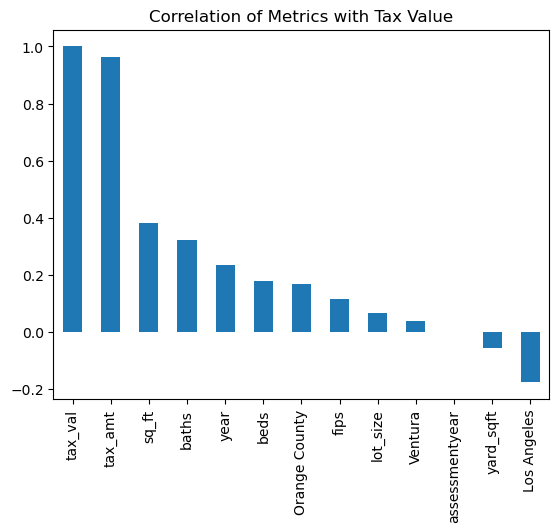

In [21]:
train.corr()['tax_val'].sort_values(ascending=False).plot(kind='bar')
plt.title('Correlation of Metrics with Tax Value')
plt.show()

<Figure size 1500x2000 with 0 Axes>

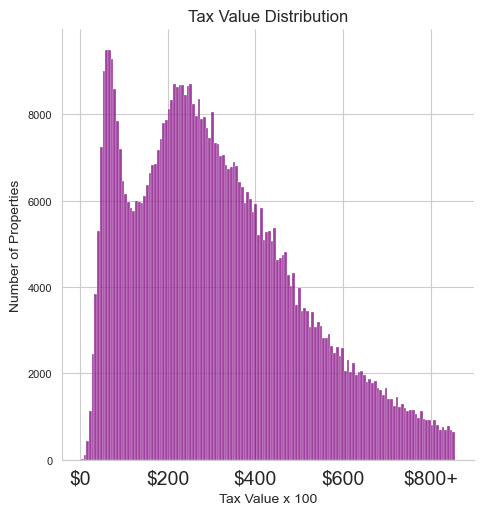

In [22]:
plt.figure(figsize=(15,20))
sb.set_style('whitegrid')
target=sb.displot(train['tax_val'], color='purple')
target.set(title= 'Tax Value Distribution')
plt.xticks(ticks = [0, 200000, 400000, 600000, 800000], 
           labels=['$0', '$200', '$400', '$600', '$800+'])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 8)
plt.xlabel('Tax Value x 100',fontsize= 10)
plt.ylabel('Number of Properties',fontsize= 10)
plt.show()

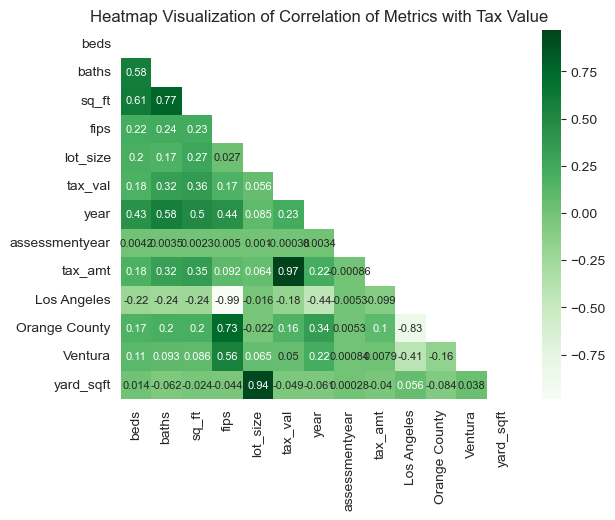

In [23]:
sb.heatmap(corr, cmap='Greens', annot=True, mask=np.triu(corr), annot_kws={"fontsize":8})
plt.title('Heatmap Visualization of Correlation of Metrics with Tax Value')
plt.show()

In [24]:
def show_corr(train):
    ''' This function will return my spearman correlation table and other visualizations
    that display the distribution of tax value/ the correlation of my metrics'''

    # Correlation table
    corr =train.corr(method='spearman')
    #Distribution of Tax Value
    plt.figure(figsize=(15,20))
    sb.set_style('whitegrid')
    target=sb.displot(train['tax_val'], color='purple')
    target.set(title= 'Tax Value Distribution')
    plt.xticks(ticks = [0, 200000, 400000, 600000, 800000], 
               labels=['$0', '$200', '$400', '$600', '$800+'])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 8)
    plt.xlabel('Tax Value x 100',fontsize= 10)
    plt.ylabel('Number of Properties',fontsize= 10)
    plt.show()
    #Correlation of Metrics to tax value
    train.corr()['tax_val'].sort_values(ascending=False).plot(kind='bar')
    plt.title('Correlation of Metrics with Tax Value')
    plt.show()
    #Heatmap
    corr = train.corr(method='spearman')
    sb.heatmap(corr, cmap='Greens', annot=False, mask = np.triu(corr), annot_kws={"fontsize":8})
    plt.title('Heatmap Visualization of Correlation of Metrics')
    plt.show()
    
    return corr

<Figure size 1500x2000 with 0 Axes>

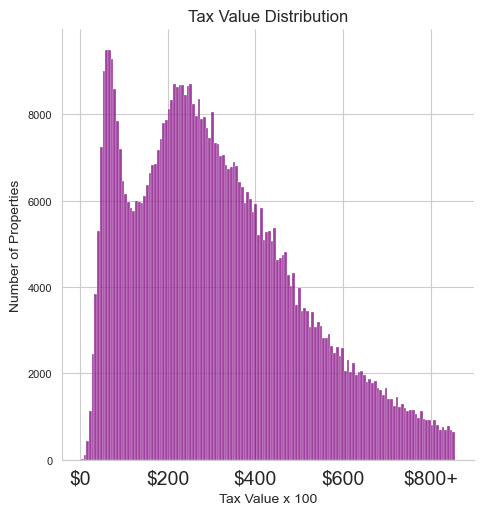

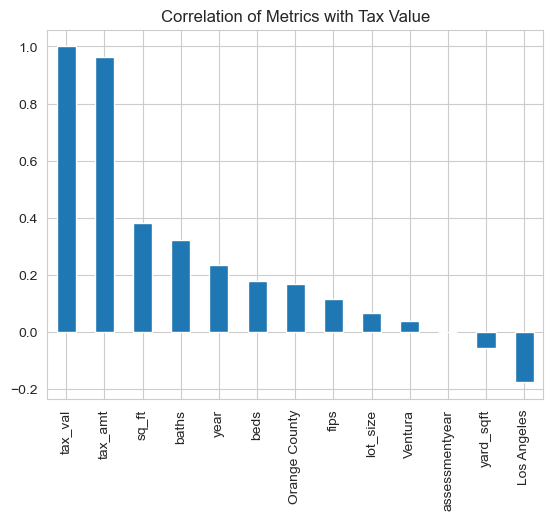

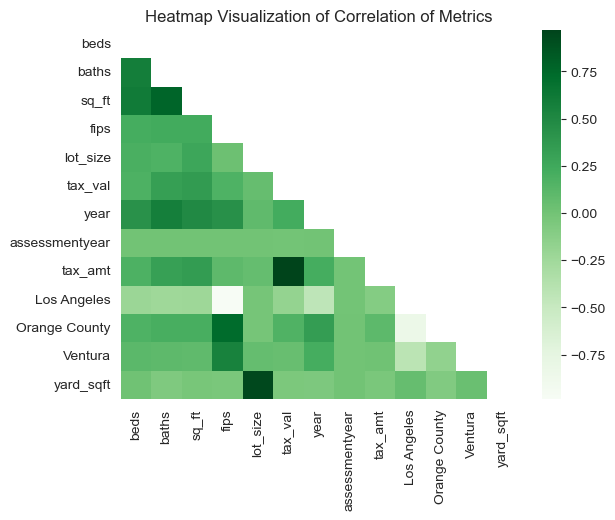

,beds,baths,sq_ft,fips,lot_size,tax_val,year,assessmentyear,tax_amt,Los Angeles,Orange County,Ventura,yard_sqft
beds,1.000000,0.584833,0.610030,0.219384,0.198572,0.182136,0.433002,0.004226,0.180112,-0.219259,0.171863,0.107806,0.014149
baths,0.584833,1.000000,0.770304,0.235187,0.170862,0.323810,0.580874,0.003471,0.318800,-0.239377,0.202503,0.093362,-0.062207
sq_ft,0.610030,0.770304,1.000000,0.230425,0.274568,0.355577,0.495558,0.002341,0.348050,-0.235562,0.202764,0.086166,-0.023573
fips,0.219384,0.235187,0.230425,1.000000,0.026654,0.170461,0.440315,0.005021,0.092006,-0.986825,0.730148,0.556157,-0.044019
lot_size,0.198572,0.170862,0.274568,0.026654,1.000000,0.055882,0.084576,0.001036,0.063747,-0.016485,-0.022000,0.065253,0.941036
tax_val,0.182136,0.323810,0.355577,0.170461,0.055882,1.000000,0.225141,-0.000384,0.971070,-0.176981,0.161482,0.049776,-0.049427
year,0.433002,0.580874,0.495558,0.440315,0.084576,0.225141,1.000000,0.003417,0.219708,-0.439759,0.343648,0.217940,-0.060863
assessmentyear,0.004226,0.003471,0.002341,0.005021,0.001036,-0.000384,0.003417,1.000000,-0.000860,-0.005334,0.005269,0.000843,0.000281
tax_amt,0.180112,0.318800,0.348050,0.092006,0.063747,0.971070,0.219708,-0.000860,1.000000,-0.099209,0.102715,0.007946,-0.039981
Los Angeles,-0.219259,-0.239377,-0.235562,-0.986825,-0.016485,-0.176981,-0.439759,-0.005334,-0.099209,1.000000,-0.831077,-0.414370,0.055659


In [154]:
show_corr(train)

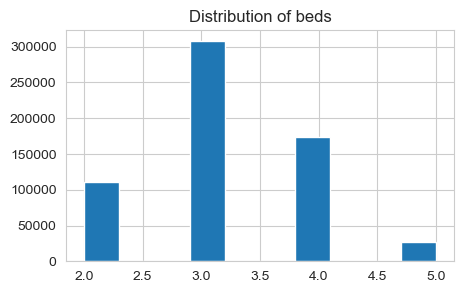

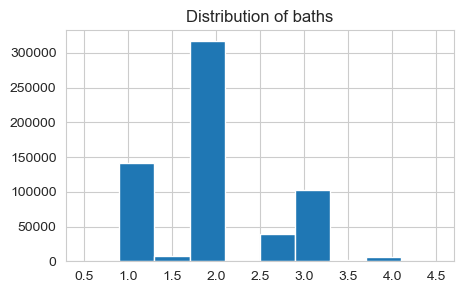

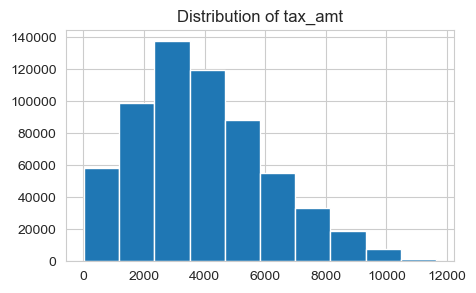

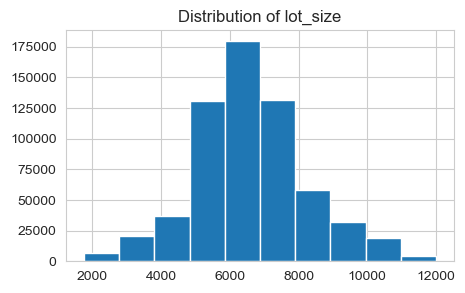

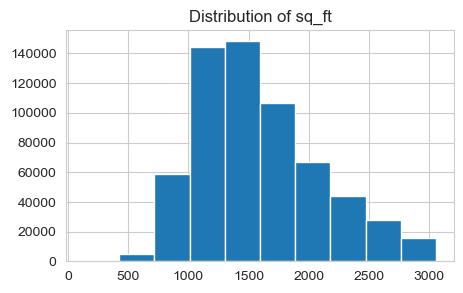

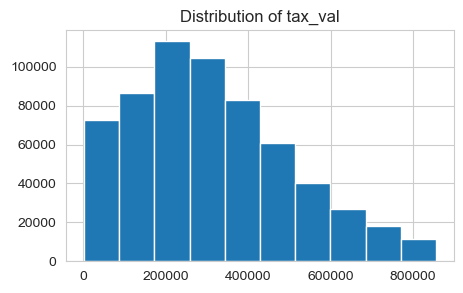

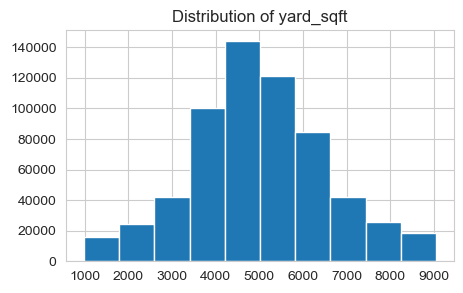

In [26]:
 for col in outliers:
    plt.figure(figsize= (5,3))
    train[col].hist()
    plt.title(f'Distribution of {col}')
    plt.show()

### Statistical Analysis

### **Q1: Do homes with more bathrooms have higher tax values?**

Null Hypothesis: Homes with more bathrooms will not have higher tax values than homes with less bathrooms

Hypothesis: Homes with more bathrooms will have higher tax values than homes with less values

In [27]:
# Finding my mode for bathroom counts to compare it to my mean. Looks like they're both 
# 2 baths. Now I can use that in my visuals
print(f' Mode of Bathrooms in dataset: {train.baths.mode()}')
print(f' Mean of Bathrooms in dataset: {round(train.baths.mean(), 2)}')
print(f' Median of Bathrooms in dataset: {train.baths.median()}')

 Mode of Bathrooms in dataset: 0    2.0
Name: baths, dtype: float64
 Mean of Bathrooms in dataset: 1.99
 Median of Bathrooms in dataset: 2.0


#### Q1.Chart 1

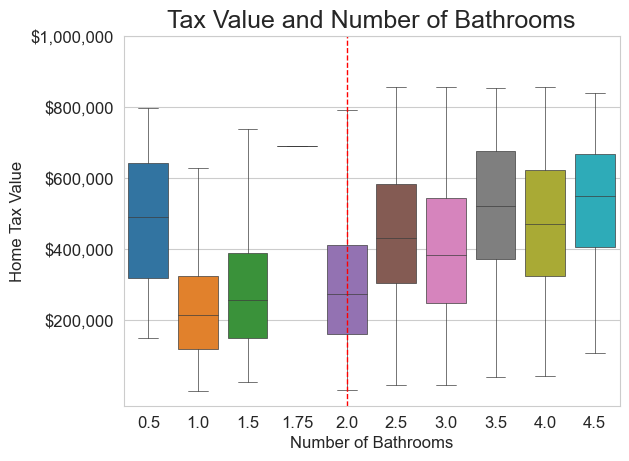

In [28]:
sb.boxplot(data=train, x='baths', y='tax_val', showfliers=False, linewidth=.5)
plt.xlabel("Number of Bathrooms", fontsize=12)
plt.ylabel("Home Tax Value", fontsize=12)
plt.title("Tax Value and Number of Bathrooms", fontsize=18)
plt.yticks([200000, 400000, 600000, 800000, 1_000_000], 
           ['$200,000', '$400,000', '$600,000', '$800,000', '$1,000,000'], fontsize=12)
plt.xticks(fontsize=12)
# Setting line at 2 to reflect my mode/mean
plt.axvline(x=4, color='red', linestyle='dashed', linewidth=1)
plt.show()

In [29]:
# Creating categories to return the tax value of homes based on the number of bathrooms
normbath= train[(train.baths <= train.baths.median())].tax_val
plusbath= train[(train.baths > train.baths.median())].tax_val

In [30]:
#Counting total mode counts of my bathroom categories
normbath.value_counts().sum(), plusbath.value_counts().sum()

(466218, 151849)

In [31]:
# Coding this out. I don't want to forget to delete this feature later. Plus, the feature above
# basically does the same thing
# train['masbeds'] = np.where(train['beds'] > 3, 1, 0)
# train['masbanos'] = np.where(train['baths'] > 2,1,0)
# yes = train[train['masbeds'] == 1].tax_val.mean()
# no = train[train['masbeds'] == 0].tax_val.mean()
# yesbth = train[train['masbanos'] == 1].tax_val.mean()
# nobth = train[train['masbanos'] == 0].tax_val.mean()

In [34]:
normbath.mean()

280362.9044588583

In [38]:
a = 0.05
t, p = stats.ttest_ind(normbath, plusbath)
if p < a:
    print(f'We reject the null hypothesis.')
    print('Average property value of properties with no more than two full bathrooms', "${:,}".format(round(normbath.mean())))
    print('Average property value of properties with more than two full bathrooms', "${:,}".format(round(plusbath.mean())))
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis.
Average property value of properties with no more than two full bathrooms $280,363
Average property value of properties with more than two full bathrooms $417,352


Note

Created a function in wrangle.py to return viz and stat test for question 1

### **Question 2: Does larger yard size increase tax value?**

**H^O:** Larger yard size decreases tax value.

**Hypothesis:** Larger yard size increases tax value.

In [39]:
train.columns

Index(['beds', 'baths', 'sq_ft', 'fips', 'lot_size', 'tax_val', 'year',
       'assessmentyear', 'tax_amt', 'county', 'Los Angeles', 'Orange County',
       'Ventura', 'yard_sqft'],
      dtype='object')

In [40]:
# Coding out. Already added this feature in prep_zillow()
# train['yard_sqft']= train['lot_size'] - train['sq_ft']
# len(train.yard_sqft.value_counts())

In [41]:
train.yard_sqft.min(), train.yard_sqft.max()

(983.0, 9047.0)

In [50]:
train['yardcats'] = pd.cut(train.yard_sqft,[974.0,2999.0,5015.0,7031.0,9047.0], labels=['small', 'medium', 'large', 'xl'])

In [51]:
train.yardcats.value_counts()

medium    268983
large     229727
xl         62252
small      57105
Name: yardcats, dtype: int64

#### Q2.Chart 1 

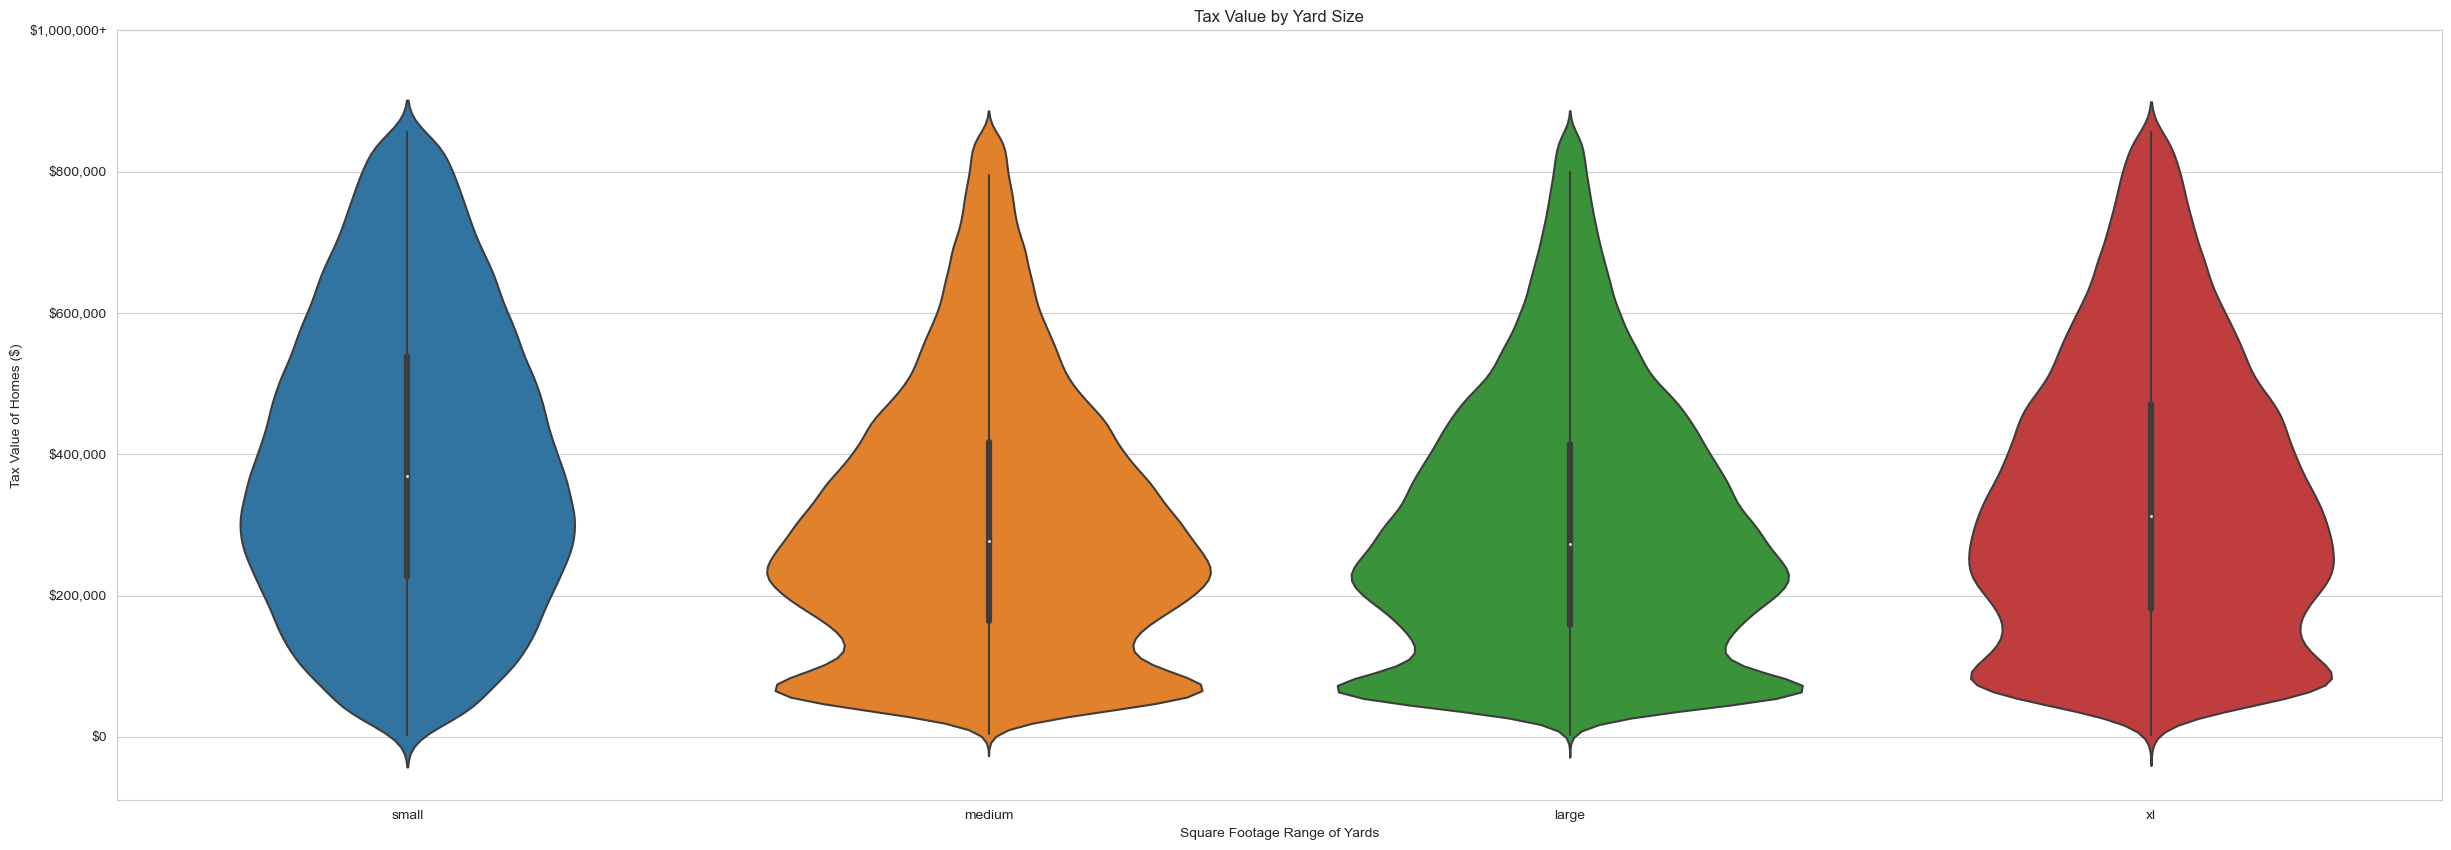

In [52]:
plt.figure(figsize=(30,10))
sb.violinplot(x='yardcats', y='tax_val', data=train, estimator=np.mean)
# plt.xticks(ticks =[(974.936, 2999.0],(2999.0, 5015.0], (5015.0, 7031.0], (7031.0, 9047.0]] , labels =)
plt.yticks(ticks= [0, 200000, 400000, 600000, 800000, 1_000_000], labels = ['$0', '$200,000', '$400,000', '$600,000', '$800,000', '$1,000,000+'])
plt.xlabel('Square Footage Range of Yards')
plt.ylabel('Tax Value of Homes ($)')
plt.title('Tax Value by Yard Size')
plt.show()

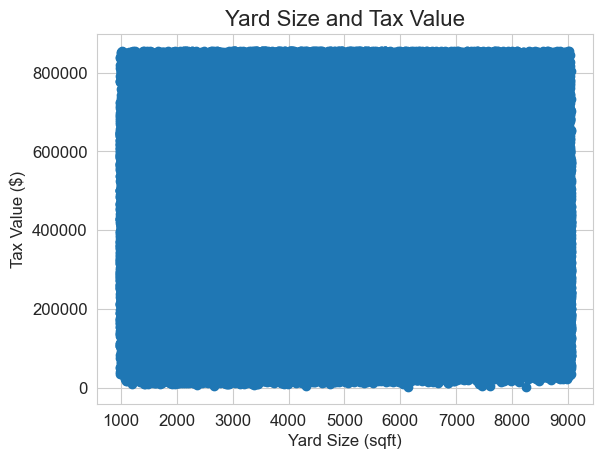

In [53]:
plt.scatter(x=train['yard_sqft'], y=train['tax_val'])
plt.title('Yard Size and Tax Value', fontsize=16)
plt.xlabel('Yard Size (sqft)', fontsize=12)
plt.ylabel('Tax Value ($)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [54]:
type(yardcats)

pandas.core.series.Series

In [56]:
a = 0.05
f, p = stats.f_oneway(train[train['yardcats'] == 'small']['tax_val'],
train[train['yardcats'] == 'medium']['tax_val'],
train[train['yardcats'] == 'large']['tax_val'],
train[train['yardcats'] == 'xl']['tax_val'])
print("ANOVA results:")
print("F-statistic:", round(f, 2))
print("p-value:", round(p, 8))
if p < a:
    print('We reject the null hypothesis')
else:

    print('We fail to reject the null hypothesis')


ANOVA results:
F-statistic: 3956.66
p-value: 0.0
We reject the null hypothesis


In [59]:
def q2_test(train):
    train['yardcats'] = pd.qcut(train['yard_sqft'], q=4, labels=['Small', 'Medium', 'Large', 'Extra Large'])

    plt.figure(figsize=(30,10))
    sb.violinplot(x='yardcats', y='tax_val', data=train, estimator=np.mean)
    plt.yticks(ticks= [0, 200000, 400000, 600000, 800000, 1_000_000], labels = ['$0', '$200,000', '$400,000', '$600,000', '$800,000', '$1,000,000+'])
    plt.xlabel('Square Footage Range of Yards')
    plt.ylabel('Tax Value of Homes ($)')
    plt.title('Tax Value by Yard Size')
    plt.show()

    a = 0.05
    f, p = stats.f_oneway(train[train['yardcats'] == 'small']['tax_val'],
    train[train['yardcats'] == 'medium']['tax_val'],
    train[train['yardcats'] == 'large']['tax_val'],
    train[train['yardcats'] == 'xl']['tax_val'])
    print("ANOVA results:")
    print("F-statistic:", round(f, 2))
    print("p-value:", round(p, 8))
    if p < a:
        print('We reject the null hypothesis')
    else:

        print('We fail to reject the null hypothesis')

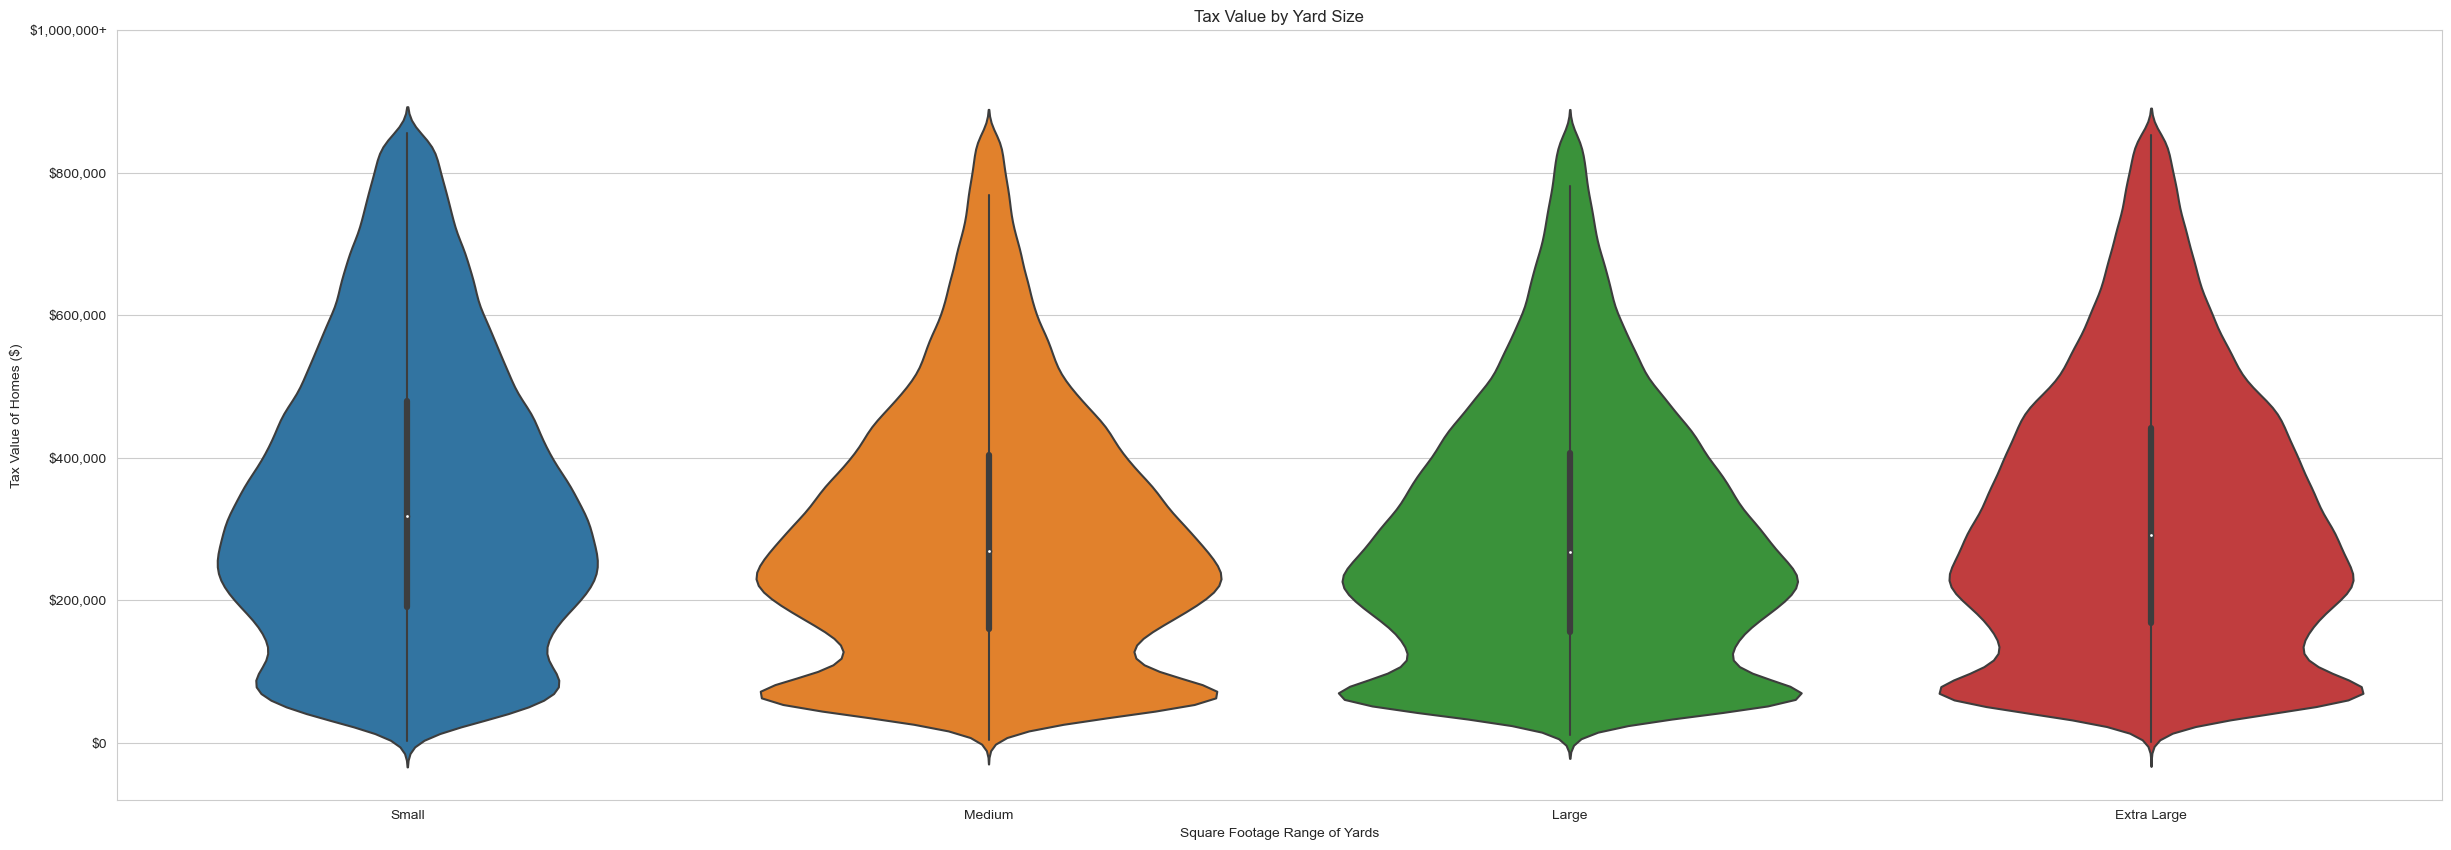

ANOVA results:
F-statistic: nan
p-value: nan
We fail to reject the null hypothesis


/Users/mackbookair/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:3869: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


In [60]:
q2_test(train)

### **Question 3: Does county location effect tax value?**

**H^O:** Tax value means will be equal across all three counties.

**Hypothesis:** Tax values will be very different across all three counties.

#### Q3.Chart 1

This chart compares the tax values of properties across all three counties and provides the average tax value

In [61]:
train.columns

Index(['beds', 'baths', 'sq_ft', 'fips', 'lot_size', 'tax_val', 'year',
       'assessmentyear', 'tax_amt', 'county', 'Los Angeles', 'Orange County',
       'Ventura', 'yard_sqft', 'yardcats'],
      dtype='object')

In [62]:
train.county.value_counts()

Los Angeles      420509
Orange County    151422
Ventura           46136
Name: county, dtype: int64

In [63]:
ventura= train[train.county == 'Ventura'].tax_val.median()
la = train[train.county == 'Los Angeles'].tax_val.median()
oc = train[train.county == 'Orange County'].tax_val.median()
ventura1= train[train.county == 'Ventura']
la1 = train[train.county == 'Los Angeles']
oc1 = train[train.county == 'Orange County']
a = 0.05

In [64]:
print(f'Median Tax Value for homes in LA County: ${la}')

Median Tax Value for homes in LA County: $259738.0


In [65]:
train.tax_val.median()

286000.0

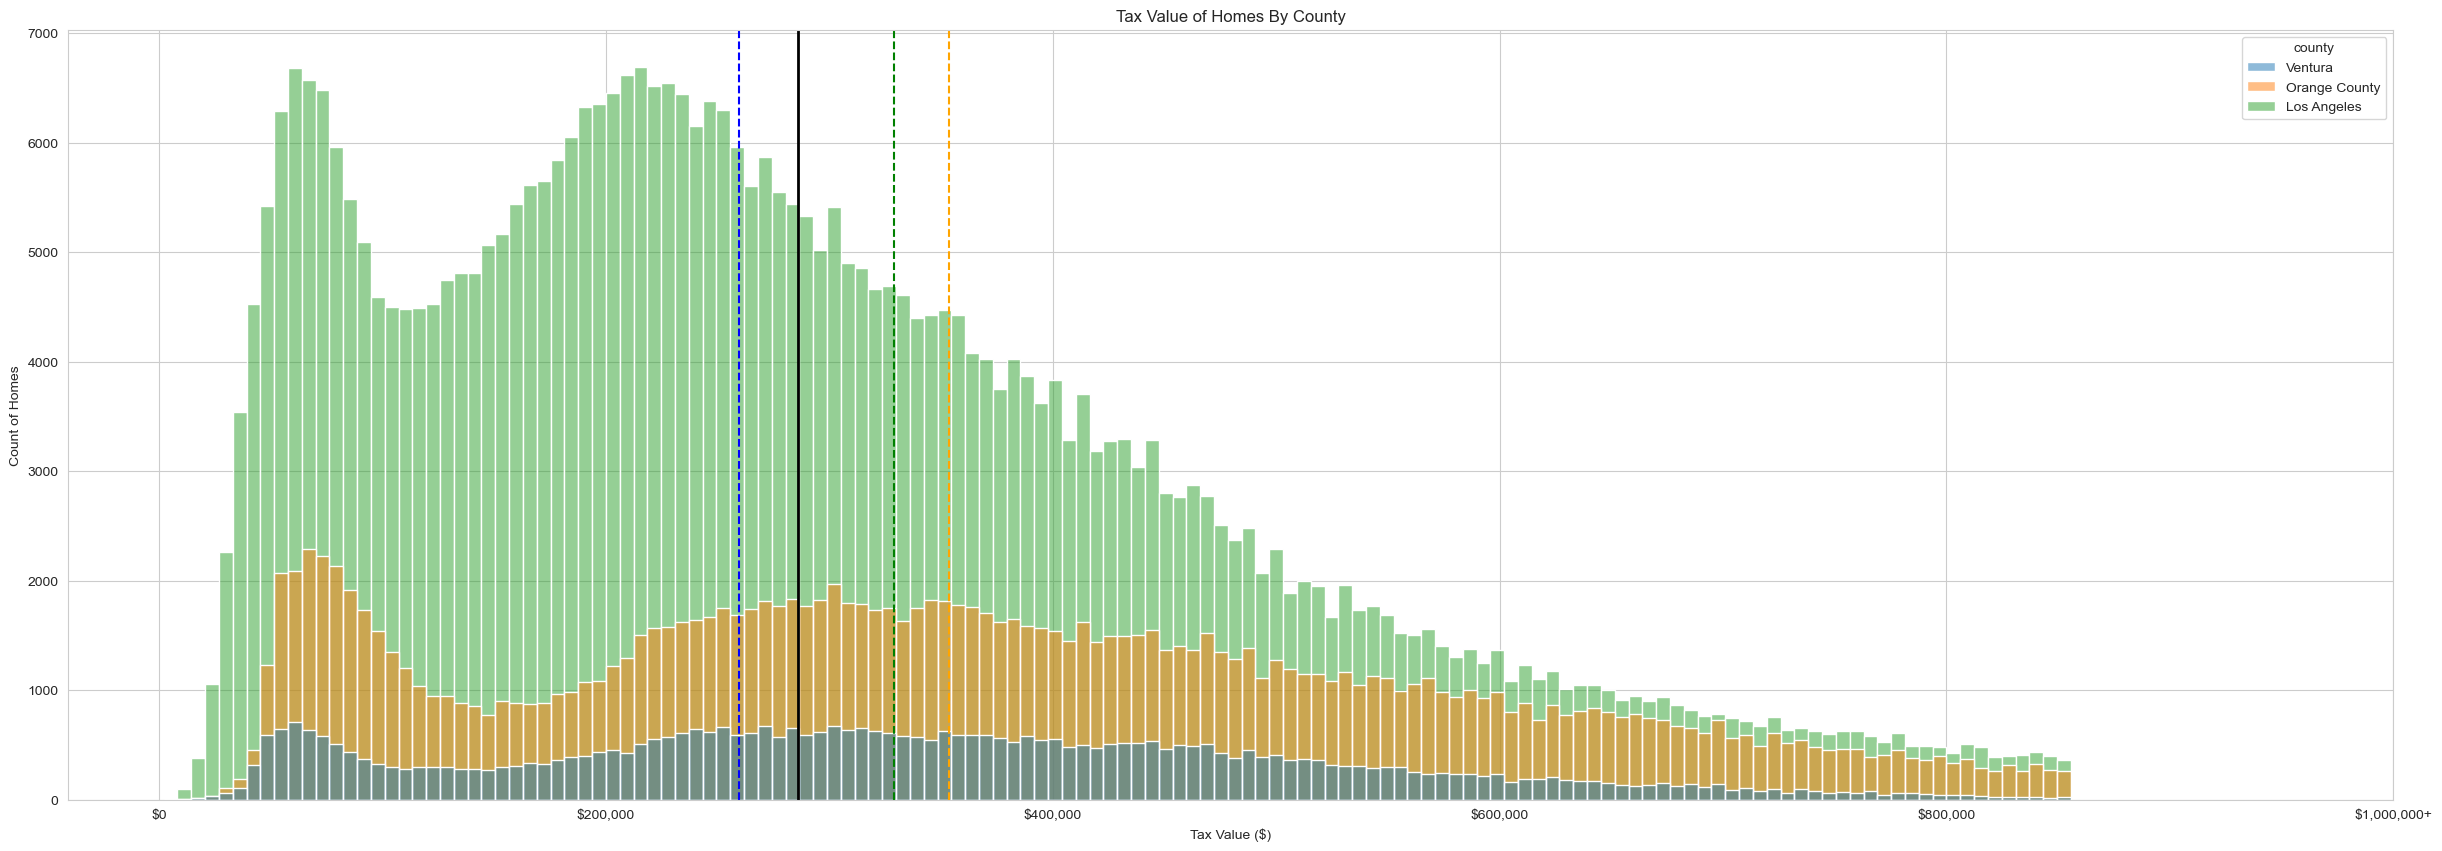

Median Tax Value for dataset: $286000.0
Median Tax Value for homes in LA County: $259738.0
Median Tax Value for homes in Orange County: $353433.5
Median Tax Value for homes in Ventura County: $329000.0


In [66]:
plt.figure(figsize=(30,10))
sb.histplot(x='tax_val', hue='county', hue_order=(['Ventura', 'Orange County', 'Los Angeles']), data=train)
plt.axvline(train['tax_val'].median(), color='black', linewidth=2)
plt.axvline(x=train[train.county == 'Orange County'].tax_val.median(), color='orange', linestyle='--')
plt.axvline(x=train[train.county == 'Los Angeles'].tax_val.median(), color='blue',linestyle='--')
plt.axvline(x=train[train.county == 'Ventura'].tax_val.median(), color='green',linestyle='--')
plt.xticks(ticks= [0, 200000, 400000, 600000, 800000, 1_000_000], labels = ['$0', '$200,000', '$400,000', '$600,000', '$800,000', '$1,000,000+'])
plt.xlabel('Tax Value ($)')
plt.ylabel('Count of Homes')
plt.title('Tax Value of Homes By County')
plt.show()

print(f'Median Tax Value for dataset: ${train.tax_val.median()}')
print(f'Median Tax Value for homes in LA County: ${la}')
print(f'Median Tax Value for homes in Orange County: ${oc}')
print(f'Median Tax Value for homes in Ventura County: ${ventura}')

In [67]:
f, p = stats.f_oneway(oc1.tax_val, ventura1.tax_val, la1.tax_val)
if p < a:
    print(f'P-value = {p}')
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

P-value = 0.0
We reject the null hypothesis


In [68]:
print(f'Mean tax value of home in LA: {round(la1.tax_val.mean(), 2)}')
print(f'Mean tax value of home in Orange County: {round(oc1.tax_val.mean(), 2)}')
print(f'Mean tax value of home in Ventura: {round(ventura1.tax_val.mean(), 2)}')
print(f'Median tax value of home in LA: {round(la1.tax_val.median(), 2)}')
print(f'Median tax value of home in Orange County: {round(oc1.tax_val.median(), 2)}')
print(f'Median tax value of home in Ventura: {round(ventura1.tax_val.median(), 2)}')

Mean tax value of home in LA: 291196.32
Mean tax value of home in Orange County: 369362.34
Mean tax value of home in Ventura: 340394.68
Median tax value of home in LA: 259738.0
Median tax value of home in Orange County: 353433.5
Median tax value of home in Ventura: 329000.0


**Observations**

- Homes in LA county have the lowest median tax values and the lowest average tax values compared to homes in Orange or Ventura counties
- The median tax value across all counties is $286,000
- Homes in Orange county have the highest median tax values

### **Q1: Do homes with more bathrooms have higher tax values?**

~~**H^O**: Homes with more bathrooms will not have higher tax values than homes with less bathrooms~~
**Hypothesis**: Homes with more bathrooms will have higher tax values than homes with less values

### **Question 2: Does larger yard size increase tax value?**

~~**H^O:** Larger yard size decreases tax value.~~

**Hypothesis:** Larger yard size increases tax value.


### **Question 3: Does county location effect tax value?**

~~**H^O:** Tax value means will be equal across all three counties.~~

**Hypothesis:** Tax values will be very different across all three counties.

## Scaling

In [69]:
#columns to scale
toscale = ['beds','baths','sq_ft','yard_sqft','Los Angeles','Orange County','Ventura']
#name scaler
mms= sklearn.preprocessing.MinMaxScaler()
mms.fit(train[toscale])

#make copies so I don't interefere with OGs
val_sc= val.copy()
test_sc= test.copy()
train_sc= train.copy()

train_sc[toscale] = pd.DataFrame(mms.transform(train[toscale]), columns=train[toscale].columns.values).set_index([train.index.values])

test_sc[toscale] = pd.DataFrame(mms.transform(test[toscale]), columns=test[toscale].columns.values).set_index([test.index.values])

val_sc[toscale] = pd.DataFrame(mms.transform(val[toscale]), columns=val[toscale].columns.values).set_index([val.index.values])

train_sc, val_sc, test_sc

(             beds  baths     sq_ft    fips  lot_size   tax_val    year  \
 256228   0.333333  0.375  0.380171  6059.0    6100.0   68944.0  1968.0   
 1313460  0.333333  0.125  0.578462  6037.0    3530.0  345000.0  1923.0   
 1415544  0.000000  0.125  0.342906  6037.0    6314.0  209983.0  1938.0   
 1490965  0.000000  0.125  0.277607  6037.0    9782.0  269237.0  1926.0   
 1093359  0.333333  0.375  0.370256  6037.0    5471.0  351730.0  1942.0   
 ...           ...    ...       ...     ...       ...       ...     ...   
 494886   0.333333  0.625  0.731624  6037.0    6725.0  468876.0  2003.0   
 671737   0.333333  0.375  0.575385  6037.0    6502.0  592756.0  1929.0   
 1435876  1.000000  0.625  0.778803  6037.0    6078.0  220309.0  1977.0   
 375833   0.666667  0.625  0.839316  6059.0    4800.0  306330.0  2014.0   
 1267855  1.000000  0.625  0.709744  6059.0    7200.0  542111.0  1971.0   
 
          assessmentyear  tax_amt         county  Los Angeles  Orange County  \
 256228           

In [70]:
train.head(2)

,beds,baths,sq_ft,fips,lot_size,tax_val,year,assessmentyear,tax_amt,county,Los Angeles,Orange County,Ventura,yard_sqft,yardcats
256228,3.0,2.0,1244.0,6059.0,6100.0,68944.0,1968.0,2016.0,1011.66,Orange County,0,1,0,4856.0,Medium
1313460,3.0,1.0,1824.0,6037.0,3530.0,345000.0,1923.0,2016.0,4287.94,Los Angeles,1,0,0,1706.0,Small


In [71]:
train_sc.head(2)

,beds,baths,sq_ft,fips,lot_size,tax_val,year,assessmentyear,tax_amt,county,Los Angeles,Orange County,Ventura,yard_sqft,yardcats
256228,0.333333,0.375,0.380171,6059.0,6100.0,68944.0,1968.0,2016.0,1011.66,Orange County,0.0,1.0,0.0,0.480283,Medium
1313460,0.333333,0.125,0.578462,6037.0,3530.0,345000.0,1923.0,2016.0,4287.94,Los Angeles,1.0,0.0,0.0,0.089658,Small


In [152]:
def scaling(train, val, test, toscale):
    """ Takes in train, val, test datasets and scales the data using MinMaxScaler and returns new scaled dataframes"""
    #columns to scale
    toscale = ['beds','baths','sq_ft','yard_sqft','Los Angeles','Orange County','Ventura', 'tax_val']
    #name scaler
    mms= sklearn.preprocessing.MinMaxScaler()
    mms.fit(train[toscale])

    #make copies so I don't interefere with OGs
    val_sc= val.copy()
    test_sc= test.copy()
    train_sc= train.copy()

    train_sc[toscale] = pd.DataFrame(mms.transform(train[toscale]), columns=train[toscale].columns.values).set_index([train.index.values])

    test_sc[toscale] = pd.DataFrame(mms.transform(test[toscale]), columns=test[toscale].columns.values).set_index([test.index.values])

    val_sc[toscale] = pd.DataFrame(mms.transform(val[toscale]), columns=val[toscale].columns.values).set_index([val.index.values])

    return train_sc, val_sc, test_sc

In [153]:
scaling(train, val, test, toscale)

(             beds  baths     sq_ft    fips  lot_size   tax_val    year  \
 256228   0.333333  0.375  0.380171  6059.0    6100.0  0.078332  1968.0   
 1313460  0.333333  0.125  0.578462  6037.0    3530.0  0.401737  1923.0   
 1415544  0.000000  0.125  0.342906  6037.0    6314.0  0.243562  1938.0   
 1490965  0.000000  0.125  0.277607  6037.0    9782.0  0.312979  1926.0   
 1093359  0.333333  0.375  0.370256  6037.0    5471.0  0.409621  1942.0   
 ...           ...    ...       ...     ...       ...       ...     ...   
 494886   0.333333  0.625  0.731624  6037.0    6725.0  0.546860  2003.0   
 671737   0.333333  0.375  0.575385  6037.0    6502.0  0.691988  1929.0   
 1435876  1.000000  0.625  0.778803  6037.0    6078.0  0.255659  1977.0   
 375833   0.666667  0.625  0.839316  6059.0    4800.0  0.356435  2014.0   
 1267855  1.000000  0.625  0.709744  6059.0    7200.0  0.632656  1971.0   
 
          assessmentyear  tax_amt         county  Los Angeles  Orange County  \
 256228           

In [72]:
#Set targets and features for modeling
X_train = train_sc[['beds','baths','sq_ft','yard_sqft','Los Angeles','Orange County','Ventura']]
y_train = train["tax_val"]
X_test = test_sc[['beds','baths','sq_ft','yard_sqft','Los Angeles','Orange County','Ventura']]
y_test = test["tax_val"]
X_val = val_sc[['beds','baths','sq_ft','yard_sqft','Los Angeles','Orange County','Ventura']]
y_val = val["tax_val"]

In [73]:
type(y_val)

pandas.core.series.Series

In [74]:
#Make ys into dataframes
y_train=pd.DataFrame(y_train)
y_val=pd.DataFrame(y_val)
y_test=pd.DataFrame(y_test)

## Modeling


#### Features kept:
- beds
- baths
- tax_val
- sq_ft
- Los Angeles
- Orange County
- Ventura
- yard_sqft



In [75]:
#Establish Baseline using mean
baseline_mean= y_train.tax_val.mean()
baseline_median= y_train.tax_val.median()
y_train['baseline_mean'] = baseline_mean
y_train['baseline_median']= baseline_median
y_val['baseline_mean'] = baseline_mean
y_val['baseline_median']= baseline_median

# Calculate rmse for train, val
rmse_train=round(mean_squared_error(y_train.tax_val, y_train.baseline_mean, squared=False),2) 
rmse_val=round(mean_squared_error(y_val.tax_val, y_val.baseline_mean, squared=False), 2)
rmse_train_med=round(mean_squared_error(y_train.tax_val, y_train.baseline_median, squared=False), 2)
rmse_val_med=round(mean_squared_error(y_val.tax_val, y_val.baseline_median, squared=False), 2)

#Calculate R2


In [76]:
y_val.head(2)

,tax_val,baseline_mean,baseline_median
311978,239600.0,314018.878332,286000.0
1004974,75684.0,314018.878332,286000.0


In [77]:
# y_train.tax_val.mean()
print(f' RMSE Train Median: ${rmse_train_med}')
print(f' RMSE Validate Median: ${rmse_val_med}')
print(f' RMSE Train Mean: ${rmse_train}')
print(f' RMSE Train Mean: ${rmse_val}')


 RMSE Train Median: $190630.03
 RMSE Validate Median: $190283.44
 RMSE Train Mean: $188559.68
 RMSE Train Mean: $188282.18


#### Base Model Differences

In [137]:
r2_train= explained_variance_score(y_train.tax_val, y_train.baseline_mean)
r2_val = explained_variance_score(y_val.tax_val, y_val.baseline_mean)
difference = rmse_train-rmse_val
difference_med = rmse_train_med-rmse_val_med

results = pd.DataFrame( data=[{'model' : 'Baseline Mean',
                         'Train RMSE': '${:,.2f}'.format(rmse_train),
                         'Validate RMSE': '${:,.2f}'.format(rmse_val), 
                         'Difference': difference}])
results_med = pd.DataFrame( data=[{'model' : 'Baseline Median',
                         'Train RMSE': '${:,.2f}'.format(rmse_train_med),
                         'Validate RMSE': '${:,.2f}'.format(rmse_train_med),
                         'Difference': difference_med}])                       

In [138]:
results

,model,Train RMSE,Validate RMSE,Difference
0,Baseline Mean,"$188,559.68","$188,282.18",277.5


In [139]:
results_med

,model,Train RMSE,Validate RMSE,Difference
0,Baseline Median,"$190,630.03","$190,630.03",346.59


In [140]:
# Concating to compare baseline means and medians with differences
base_results= pd.concat([results, results_med])

In [141]:
base_results

,model,Train RMSE,Validate RMSE,Difference
0,Baseline Mean,"$188,559.68","$188,282.18",277.50
0,Baseline Median,"$190,630.03","$190,630.03",346.59


In [135]:
def comp_rmse_mm(y_train, y_val):
    """This function will return a dataframe which allows us to compare the 
    computed rmse mean and median and their differences for the baseline models """
    #Establish Baseline using mean
    baseline_mean= y_train.tax_val.mean()
    baseline_median= y_train.tax_val.median()
    y_train['baseline_mean'] = baseline_mean
    y_train['baseline_median']= baseline_median
    y_val['baseline_mean'] = baseline_mean
    y_val['baseline_median']= baseline_median

    # Calculate rmse for train, val
    rmse_train=mean_squared_error(y_train.tax_val, y_train.baseline_mean, squared=False) 
    rmse_val=mean_squared_error(y_val.tax_val, y_val.baseline_mean, squared=False)
    rmse_train_med=mean_squared_error(y_train.tax_val, y_train.baseline_median, squared=False)
    rmse_val_med=mean_squared_error(y_val.tax_val, y_val.baseline_median, squared=False)

    # Calculate differences 
    difference = rmse_train-rmse_val
    difference_med = rmse_train_med-rmse_val_med
    # Create dataframes for mean and median rmse
    results = pd.DataFrame( data=[{'model' : 'Baseline Mean',
                             'Train RMSE': '${:,.2f}'.format(rmse_train),
                             'Validate RMSE': '${:,.2f}'.format(rmse_val), 
                             'Difference': difference}])
    results_med = pd.DataFrame( data=[{'model' : 'Baseline Median',
                             'Train RMSE': '${:,.2f}'.format(rmse_train_med),
                             'Validate RMSE': '${:,.2f}'.format(rmse_train_med),
                             'Difference': difference_med}])    
    # Concating to compare baseline means and medians with differences
    results = pd.concat([results, results_med])
    return results

In [136]:
# Checking for functionality
comp_rmse_mm(y_train, y_val)

,model,Train RMSE,Validate RMSE,Difference
0,Baseline Mean,"$188,559.68","$188,282.18",277.492633
0,Baseline Median,"$190,630.03","$190,630.03",346.592445


#### Target Distribution

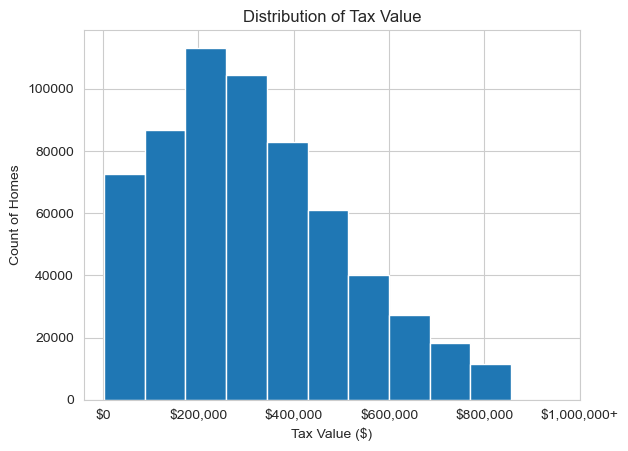

In [84]:
plt.hist(y_train.tax_val)
plt.title('Distribution of Tax Value')
plt.xticks(ticks= [0, 200000, 400000, 600000, 800000, 1_000_000], labels = ['$0', '$200,000', '$400,000', '$600,000', '$800,000', '$1,000,000+'])
plt.xlabel('Tax Value ($)')
plt.ylabel('Count of Homes')
plt.show()

In [85]:
lr = LinearRegression(normalize=True)
ll = LassoLars(alpha=1)
pf= PolynomialFeatures(degree= 5)

### MODEL 1: Polynomial Regression

In [86]:
X_train_pf = pf.fit_transform(X_train)
X_val_pf = pf.transform(X_val)

In [121]:
lr.fit(X_train_pf, y_train['tax_val'])
y_train['pf_pred'] = lr.predict(X_train_pf)
pf_rmse_train= round(mean_squared_error(y_train['tax_val'], y_train['pf_pred'], squared=False),2)

y_val['pf_pred'] = lr.predict(X_val_pf)
pf_rmse_val= round(mean_squared_error(y_val['tax_val'], y_val['pf_pred'], squared=False),2)
pfdifference = pf_rmse_train - pf_rmse_val

pf_r2_train= explained_variance_score(y_train.tax_val, y_train.pf_pred)
pf_r2_val = explained_variance_score(y_val.tax_val, y_val.pf_pred)

In [143]:
pfmetrics = pd.DataFrame(data = [{ 'model': 'PolyFeats',
                                   'Train RMSE': '${:,.2f}'.format(pf_rmse_train),
                             'Validate RMSE': '${:,.2f}'.format(pf_rmse_val),
                                   'Difference': pfdifference,
                                   'r2 Train': pf_r2_train,
                                   'r2 Validate': pf_r2_val}])



In [144]:
pfmetrics

,model,Train RMSE,Validate RMSE,Difference,r2 Train,r2 Validate
0,PolyFeats,"$171,005.85","$170,752.87",252.98,0.177522,0.17754


### MODEL 2: OLS

In [122]:
# I've already created my model objec above for linear regression, so I'll pick up from there

#Fit the model to train data
lr.fit(X_train, y_train.tax_val)

# Predict train
y_train['pred_ols'] = lr.predict(X_train)
y_val['pred_ols'] = lr.predict(X_val)

# Evaluate RMSE
ols_rmse_train = round(mean_squared_error(y_train.tax_val, y_train.pred_ols, squared=False), 2) 
ols_rmse_val = round(mean_squared_error(y_val.tax_val, y_val.pred_ols, squared=False), 2) 
olsdifference = ols_rmse_train - ols_rmse_val

# Evaluate r2
ols_r2_train= explained_variance_score(y_train.tax_val, y_train.pred_ols)
ols_r2_val = explained_variance_score(y_val.tax_val, y_val.pred_ols)

In [126]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", ols_rmse_train, 
      "\nValidation/Out-of-Sample: ", ols_rmse_val)

RMSE for OLS using LinearRegression
Training/In-Sample:  172286.18 
Validation/Out-of-Sample:  171916.93


In [145]:
olsmetrics = pd.DataFrame(data = [{ 'model': 'OLS',
                                   'Train RMSE': '${:,.2f}'.format(ols_rmse_train),
                             'Validate RMSE': '${:,.2f}'.format(ols_rmse_val),
                                   'Difference': olsdifference,
                                   'r2 Train': ols_r2_train,
                                   'r2 Validate': ols_r2_val}])

In [146]:
olsmetrics

,model,Train RMSE,Validate RMSE,Difference,r2 Train,r2 Validate
0,OLS,"$172,286.18","$171,916.93",369.25,0.16516,0.166287


### Model 3: LASSO LARS

In [128]:
#Fit the model to train data
ll.fit(X_train, y_train.tax_val)

# Predict train
y_train['pred_ll'] = ll.predict(X_train)
y_val['pred_ll'] = ll.predict(X_val)


# Evaluate RMSE
ll_rmse_train = round(mean_squared_error(y_train.tax_val, y_train.pred_ll, squared=False), 2) 
ll_rmse_val = round(mean_squared_error(y_val.tax_val, y_val.pred_ll, squared=False), 2) 
lldifference = ll_rmse_train - ll_rmse_val

# Evaluate r2
ll_r2_train= explained_variance_score(y_train.tax_val, y_train.pred_ll)
ll_r2_val = explained_variance_score(y_val.tax_val, y_val.pred_ll)

In [129]:
print("RMSE for LASSO LARS\nTraining/In-Sample: ", ll_rmse_train, 
      "\nValidation/Out-of-Sample: ", ll_rmse_val)

RMSE for LASSO LARS
Training/In-Sample:  172299.17 
Validation/Out-of-Sample:  171927.87


In [147]:
llmetrics = pd.DataFrame(data = [{ 'model': 'Lasso Lars',
                                   'Train RMSE': '${:,.2f}'.format(ll_rmse_train),
                             'Validate RMSE': '${:,.2f}'.format(ll_rmse_val),
                                   'Difference': lldifference,
                                   'r2 Train': ll_r2_train,
                                   'r2 Validate': ll_r2_val}])

In [148]:
llmetrics

,model,Train RMSE,Validate RMSE,Difference,r2 Train,r2 Validate
0,Lasso Lars,"$172,299.17","$171,927.87",371.3,0.165034,0.166181


In [149]:
pd.concat([base_results, llmetrics, olsmetrics, pfmetrics])

,model,Train RMSE,Validate RMSE,Difference,r2 Train,r2 Validate
0,Baseline Mean,"$188,559.68","$188,282.18",277.50,NaN,NaN
0,Baseline Median,"$190,630.03","$190,630.03",346.59,NaN,NaN
0,Lasso Lars,"$172,299.17","$171,927.87",371.30,0.165034,0.166181
0,OLS,"$172,286.18","$171,916.93",369.25,0.165160,0.166287
0,PolyFeats,"$171,005.85","$170,752.87",252.98,0.177522,0.177540


Best model : Polynomial Features

In [150]:
def comp_models(X_train, y_train, X_val, y_val):
    '''This model calculates the train/val rmse for Lasso Lars, OLS, and Polynomial
    features models and compares them to the baseline on a concatenated dataframe'''
    
    # Baseline
    baseline_mean= y_train.tax_val.mean()
    baseline_median= y_train.tax_val.median()
    y_train['baseline_mean'] = baseline_mean
    y_train['baseline_median']= baseline_median
    y_val['baseline_mean'] = baseline_mean
    y_val['baseline_median']= baseline_median
    # Calculate rmse for train, val
    rmse_train=mean_squared_error(y_train.tax_val, y_train.baseline_mean, squared=False) 
    rmse_val=mean_squared_error(y_val.tax_val, y_val.baseline_mean, squared=False)
    rmse_train_med=mean_squared_error(y_train.tax_val, y_train.baseline_median, squared=False)
    rmse_val_med=mean_squared_error(y_val.tax_val, y_val.baseline_median, squared=False)
    # Calculate differences 
    difference = rmse_train-rmse_val
    difference_med = rmse_train_med-rmse_val_med
    # Create dataframes for mean and median rmse
    results = pd.DataFrame( data=[{'model' : 'Baseline Mean',
                             'Train RMSE': '${:,.2f}'.format(rmse_train),
                             'Validate RMSE': '${:,.2f}'.format(rmse_val), 
                             'Difference': difference}])
    results_med = pd.DataFrame( data=[{'model' : 'Baseline Median',
                             'Train RMSE': '${:,.2f}'.format(rmse_train_med),
                             'Validate RMSE': '${:,.2f}'.format(rmse_train_med),
                             'Difference': difference_med}])    
    # Concating to compare baseline means and medians with differences
    base_results = pd.concat([results, results_med])
    
    #PolyFeats
    
    lr.fit(X_train_pf, y_train['tax_val'])
    y_train['pf_pred'] = lr.predict(X_train_pf)
    pf_rmse_train= round(mean_squared_error(y_train['tax_val'], y_train['pf_pred'], squared=False),2)

    y_val['pf_pred'] = lr.predict(X_val_pf)
    pf_rmse_val= round(mean_squared_error(y_val['tax_val'], y_val['pf_pred'], squared=False),2)
    pfdifference = pf_rmse_train - pf_rmse_val

    pf_r2_train= explained_variance_score(y_train.tax_val, y_train.pf_pred)
    pf_r2_val = explained_variance_score(y_val.tax_val, y_val.pf_pred)
    
    pfmetrics = pd.DataFrame(data = [{ 'model': 'PolyFeats',
                                   'Train RMSE': '${:,.2f}'.format(pf_rmse_train),
                             'Validate RMSE': '${:,.2f}'.format(pf_rmse_val),
                                   'Difference': pfdifference,
                                   'r2 Train': pf_r2_train,
                                   'r2 Validate': pf_r2_val}])
    # OLS
    
    #Fit the model to train data
    lr.fit(X_train, y_train.tax_val)

    # Predict train
    y_train['pred_ols'] = lr.predict(X_train)
    y_val['pred_ols'] = lr.predict(X_val)

    # Evaluate RMSE
    ols_rmse_train = round(mean_squared_error(y_train.tax_val, y_train.pred_ols, squared=False), 2) 
    ols_rmse_val = round(mean_squared_error(y_val.tax_val, y_val.pred_ols, squared=False), 2) 
    olsdifference = ols_rmse_train - ols_rmse_val

    # Evaluate r2
    ols_r2_train= explained_variance_score(y_train.tax_val, y_train.pred_ols)
    ols_r2_val = explained_variance_score(y_val.tax_val, y_val.pred_ols)
    
    olsmetrics = pd.DataFrame(data = [{ 'model': 'OLS',
                                   'Train RMSE': '${:,.2f}'.format(ols_rmse_train),
                             'Validate RMSE': '${:,.2f}'.format(ols_rmse_val),
                                   'Difference': olsdifference,
                                   'r2 Train': ols_r2_train,
                                   'r2 Validate': ols_r2_val}])
    
    #LASSO LARS

        #Fit the model to train data
    ll.fit(X_train, y_train.tax_val)

    # Predict train
    y_train['pred_ll'] = ll.predict(X_train)
    y_val['pred_ll'] = ll.predict(X_val)


    # Evaluate RMSE
    ll_rmse_train = round(mean_squared_error(y_train.tax_val, y_train.pred_ll, squared=False), 2) 
    ll_rmse_val = round(mean_squared_error(y_val.tax_val, y_val.pred_ll, squared=False), 2) 
    lldifference = ll_rmse_train - ll_rmse_val

    # Evaluate r2
    ll_r2_train= explained_variance_score(y_train.tax_val, y_train.pred_ll)
    ll_r2_val = explained_variance_score(y_val.tax_val, y_val.pred_ll)

    llmetrics = pd.DataFrame(data = [{ 'model': 'Lasso Lars',
                                       'Train RMSE': '${:,.2f}'.format(ll_rmse_train),
                                 'Validate RMSE': '${:,.2f}'.format(ll_rmse_val),
                                       'Difference': lldifference,
                                       'r2 Train': ll_r2_train,
                                       'r2 Validate': ll_r2_val}])
    # Final DF
    
    final_results = pd.concat([base_results, llmetrics, olsmetrics, pfmetrics])
    
    return final_results

In [151]:
comp_models(X_train, y_train, X_val, y_val)

,model,Train RMSE,Validate RMSE,Difference,r2 Train,r2 Validate
0,Baseline Mean,"$188,559.68","$188,282.18",277.492633,NaN,NaN
0,Baseline Median,"$190,630.03","$190,630.03",346.592445,NaN,NaN
0,Lasso Lars,"$172,299.17","$171,927.87",371.300000,0.165034,0.166181
0,OLS,"$172,286.18","$171,916.93",369.250000,0.165160,0.166287
0,PolyFeats,"$171,005.85","$170,752.87",252.980000,0.177522,0.177540
